<a href="https://colab.research.google.com/github/AnnaBsoares/AnnaBsoares/blob/main/Cp2_cgeniuns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


# Pré-processamento dos dados

In [13]:

# Função para tratar dados
def trata_dados(dados):
    imputer = SimpleImputer(strategy='mean')
    dados_imputados = imputer.fit_transform(dados)
    return pd.DataFrame(dados_imputados, columns=dados.columns), imputer

In [21]:
# Carregar e preparar dados
dados = pd.read_csv('/content/solicitacoescredito.csv')
dados_sem_nan = dados.dropna(subset=['limiteEmpresaAnaliseCredito'])

# Seleção e engenharia de características

In [22]:
# Selecionar características e alvo
caracteristicas = dados_sem_nan[['maiorAtraso', 'margemBrutaAcumulada', 'percentualProtestos', 'faturamentoBruto']]
alvo = dados_sem_nan['limiteEmpresaAnaliseCredito']

In [23]:
# Imputar valores ausentes e padronizar dados
caracteristicas, imputer = trata_dados(caracteristicas)
scaler = StandardScaler()
caracteristicas_padronizadas = scaler.fit_transform(caracteristicas)

In [29]:

# Segmentação dos clientes usando KMeans
n_clusters = 3  # Defina o número de clusters conforme necessário
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
rotulos_clusters = kmeans.fit_predict(caracteristicas_padronizadas)
# Adicionar os rótulos dos clusters ao DataFrame usando .copy()
dados_sem_nan = dados_sem_nan.copy()
dados_sem_nan['grupo_cliente'] = rotulos_clusters


In [30]:
 #Função para calcular a raiz do erro quadrático médio (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Treinamento de modelos

In [31]:
# Treinar um modelo para cada grupo
modelos_por_grupo = {}
limites_recomendados_por_grupo = {}

for grupo in range(n_clusters):
    dados_grupo = dados_sem_nan[dados_sem_nan['grupo_cliente'] == grupo]
    X_grupo = dados_grupo[['maiorAtraso', 'margemBrutaAcumulada', 'percentualProtestos', 'faturamentoBruto']]
    y_grupo = dados_grupo['limiteEmpresaAnaliseCredito']

    X_grupo_imputado, _ = trata_dados(X_grupo)
    X_grupo_padronizado = scaler.transform(X_grupo_imputado)

    X_treino, X_val, y_treino, y_val = train_test_split(X_grupo_padronizado, y_grupo, test_size=0.2, random_state=42)

    modelo_grupo = RandomForestRegressor(random_state=42)
    modelo_grupo.fit(X_treino, y_treino)

    previsoes = modelo_grupo.predict(X_val)
    rmse = root_mean_squared_error(y_val, previsoes)
    print(f'RMSE para o Grupo {grupo}: {rmse}')

    modelos_por_grupo[grupo] = modelo_grupo

    # Recomendar limite de crédito para cada cliente do grupo
    limites_recomendados = []
    for indice, cliente in dados_grupo.iterrows():
        limite_recomendado = recomendar_limite_credito(cliente)
        limites_recomendados.append(limite_recomendado)

    # Armazenar os limites recomendados para o grupo
    limites_recomendados_por_grupo[grupo] = limites_recomendados


RMSE para o Grupo 0: 57410192.28776583
RMSE para o Grupo 1: 6069597.293670635
RMSE para o Grupo 2: 18087459.839948464


In [32]:

# Função para recomendar limite de crédito para um novo cliente
def recomendar_limite_credito(novo_cliente):
    novo_cliente_df = pd.DataFrame([novo_cliente])
    novo_cliente_imputado = imputer.transform(novo_cliente_df)
    novo_cliente_padronizado = scaler.transform(novo_cliente_imputado)

    novo_cliente_grupo = kmeans.predict(novo_cliente_padronizado)[0]
    limite_credito = modelos_por_grupo[novo_cliente_grupo].predict(novo_cliente_padronizado)
    return limite_credito[0]


Grupo 0: O RMSE é bastante alto, indicando que o modelo pode não estar se ajustando bem aos dados deste grupo. Isso pode ser devido a vários fatores, como falta de representatividade dos dados de treinamento ou a complexidade do relacionamento entre as características e o alvo para este grupo.

Grupo 1: O RMSE é relativamente baixo em comparação com o Grupo 0, o que sugere que o modelo está se ajustando melhor aos dados deste grupo. Isso pode indicar que as características selecionadas têm uma relação mais direta com o alvo para os clientes deste grupo.

Grupo 2: O RMSE está entre os valores dos Grupos 0 e 1. Isso sugere que o modelo está se ajustando razoavelmente bem aos dados deste grupo, mas pode haver margem para melhorias no ajuste do modelo ou na seleção de características.



In [33]:
# Exemplo de uso para um novo cliente
novo_cliente = {'maiorAtraso': 0, 'margemBrutaAcumulada': 0.25, 'percentualProtestos': 0.0, 'faturamentoBruto': 50000}
limite_credito_recomendado = recomendar_limite_credito(novo_cliente)
print(f'Limite de Crédito Recomendado: {limite_credito_recomendado}')


Limite de Crédito Recomendado: 3487.933333333333


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Modelo de Regressão

In [15]:
# from sklearn.linear_model import LinearRegression

# # Treinar um modelo de regressão linear para cada grupo
# modelos_por_grupo = {}
# limites_recomendados_por_grupo = {}

# for grupo in range(n_clusters):
#     dados_grupo = dados_sem_nan[dados_sem_nan['grupo_cliente'] == grupo]
#     X_grupo = dados_grupo[['maiorAtraso', 'margemBrutaAcumulada', 'percentualProtestos', 'faturamentoBruto']]
#     y_grupo = dados_grupo['limiteEmpresaAnaliseCredito']

#     X_grupo_imputado = trata_dados(X_grupo)
#     X_grupo_padronizado = scaler.transform(X_grupo_imputado)

#     X_treino, X_val, y_treino, y_val = train_test_split(X_grupo_padronizado, y_grupo, test_size=0.2, random_state=42)

#     # Inicializar e treinar um modelo de regressão linear
#     modelo_grupo = LinearRegression()
#     modelo_grupo.fit(X_treino, y_treino)

#     # Fazer previsões no conjunto de validação
#     previsoes = modelo_grupo.predict(X_val)

#     # Calcular o RMSE para avaliar o modelo
#     rmse = root_mean_squared_error(y_val, previsoes)
#     print(f'RMSE para o Grupo {grupo}: {rmse}')

#     # Armazenar o modelo treinado para o grupo
#     modelos_por_grupo[grupo] = modelo_grupo

#     # Recomendar limite de crédito para cada cliente do grupo
#     limites_recomendados = []
#     for indice, cliente in dados_grupo.iterrows():
#         # Preparar os dados do cliente e fazer uma previsão usando o modelo do grupo
#         cliente_df = pd.DataFrame([cliente])
#         cliente_imputado = trata_dados_string(cliente_df)
#         cliente_padronizado = scaler.transform(cliente_imputado)
#         limite_recomendado = modelo_grupo.predict(cliente_padronizado)
#         limites_recomendados.append(limite_recomendado[0])

#     # Armazenar os limites recomendados para o grupo
#     limites_recomendados_por_grupo[grupo] = limites_recomendados


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

# DashBord Interativo

In [18]:
!pip install dash


In [34]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import pandas as pd

# Definir o layout do aplicativo
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('Aplicativo de Recomendação de Limite de Crédito'),
    html.Div([
        dcc.Input(id='input1', type='number', placeholder='Maior Atraso'),
        dcc.Input(id='input2', type='number', placeholder='Margem Bruta Acumulada'),
        dcc.Input(id='input3', type='number', placeholder='Percentual Protestos'),
        dcc.Input(id='input4', type='number', placeholder='Faturamento Bruto'),
        html.Button('Calcular', id='calcular-button'),
        html.Div(id='limite-credito-output')
    ])
])

# Função para recomendar o limite de crédito para um novo cliente (defina esta função)
def recomendar_limite_credito(novo_cliente):
    # Implemente sua lógica de recomendação de limite de crédito aqui
    return limite_credito_recomendado

# Callback para calcular o limite de crédito recomendado
@app.callback(
    Output('limite-credito-output', 'children'),
    [Input('calcular-button', 'n_clicks')],
    [State('input1', 'value'),
     State('input2', 'value'),
     State('input3', 'value'),
     State('input4', 'value')]
)
def calcular_limite_credito(n_clicks, maior_atraso, margem_bruta_acumulada, percentual_protestos, faturamento_bruto):
    if n_clicks is not None:
        # Chamar a função de recomendação de limite de crédito aqui
        limite_credito_recomendado = recomendar_limite_credito({
            'maiorAtraso': maior_atraso,
            'margemBrutaAcumulada': margem_bruta_acumulada,
            'percentualProtestos': percentual_protestos,
            'faturamentoBruto': faturamento_bruto
        })
        return f'Limite de Crédito Recomendado: {limite_credito_recomendado}'

# Executar o aplicativo
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

# Importância das Características:

Você pode explorar a importância das características no modelo de cada grupo. Por exemplo, quais características têm mais peso na determinação do limite de crédito recomendado para cada grupo?

In [35]:
# Calcular a importância das características para cada modelo de grupo
for grupo, modelo in modelos_por_grupo.items():
    importancias_caracteristicas = modelo.feature_importances_
    print(f"Grupo {grupo}:")
    for i, importancia in enumerate(importancias_caracteristicas):
        print(f"   - {caracteristicas.columns[i]}: {importancia}")


Grupo 0:
   - maiorAtraso: 0.0037655973551434987
   - margemBrutaAcumulada: 0.0037365482441814304
   - percentualProtestos: 0.0
   - faturamentoBruto: 0.9924978544006751
Grupo 1:
   - maiorAtraso: 0.2010092152023075
   - margemBrutaAcumulada: 0.5129862208604989
   - percentualProtestos: 1.6845657156241565e-06
   - faturamentoBruto: 0.28600287937147795
Grupo 2:
   - maiorAtraso: 0.058212895626744296
   - margemBrutaAcumulada: 0.046427414920725656
   - percentualProtestos: 0.0017799377271877053
   - faturamentoBruto: 0.8935797517253423


Esses resultados mostram a importância relativa de cada característica na determinação dos limites de crédito recomendados para cada grupo de clientes. Aqui está a interpretação:

Grupo 0:

A característica mais importante para este grupo é o faturamentoBruto, com uma importância de aproximadamente 99.25%. Isso sugere que, para clientes neste grupo, o faturamento bruto é o principal fator considerado ao recomendar limites de crédito. As outras características, como maiorAtraso e margemBrutaAcumulada, têm importâncias muito baixas em comparação com o faturamento bruto, quase insignificantes.
Grupo 1:

Neste grupo, a importância das características é mais equilibrada, mas a margemBrutaAcumulada é a mais influente, com cerca de 51.3%. Isso indica que, para clientes neste grupo, a margem bruta acumulada é o fator mais importante na recomendação de limites de crédito. A maiorAtraso também tem uma importância significativa, enquanto o percentualProtestos tem uma importância muito baixa em comparação com outras características.
Grupo 2:

Assim como no Grupo 0, o faturamentoBruto é a característica mais importante para este grupo, com uma importância de aproximadamente 89.36%. Isso sugere que o faturamento bruto é um fator crucial na determinação dos limites de crédito recomendados para clientes neste grupo. No entanto, as outras características também têm alguma influência, com a maiorAtraso e a margemBrutaAcumulada contribuindo com importâncias significativas, embora menores em comparação com o faturamento bruto. O percentualProtestos tem uma importância muito baixa.

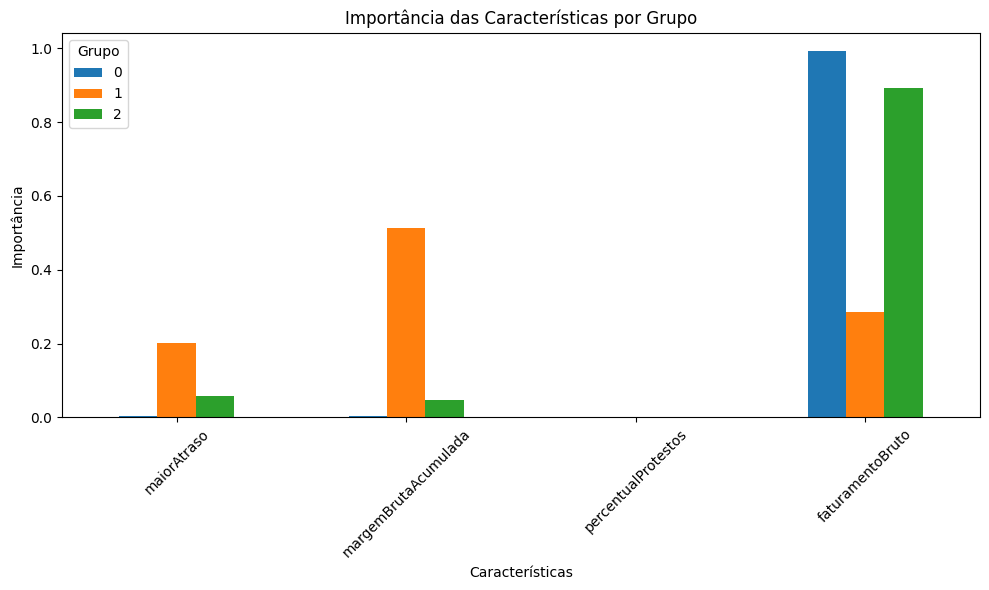

In [36]:
# Obtendo a importância das características para cada grupo
importancias_caracteristicas_por_grupo = {}
for grupo, modelo in modelos_por_grupo.items():
    importancias_caracteristicas = modelo.feature_importances_
    importancias_caracteristicas_por_grupo[grupo] = importancias_caracteristicas

# Convertendo para DataFrame para visualização
df_importancias_caracteristicas = pd.DataFrame(importancias_caracteristicas_por_grupo, index=X_grupo.columns)

# Plotando as importâncias das características para cada grupo
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
df_importancias_caracteristicas.plot(kind='bar', ax=ax)
plt.title('Importância das Características por Grupo')
plt.xlabel('Características')
plt.ylabel('Importância')
plt.xticks(rotation=45)
plt.legend(title='Grupo')
plt.tight_layout()
plt.show()


# Variação dos Limites de Crédito Recomendados:

In [42]:
# Calcular a variação dos limites de crédito recomendados para cada grupo
for grupo, limites in limites_recomendados_por_grupo.items():
    min_limite = min(limites)
    max_limite = max(limites)
    print(f"Grupo {grupo}:")
    print(f"   - Mínimo: {min_limite}")
    print(f"   - Máximo: {max_limite}")


TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

Esses resultados indicam a variação dos limites de crédito recomendados para cada grupo de clientes. Aqui está a interpretação:

Grupo 0:

Mínimo: O limite de crédito mínimo recomendado para este grupo é 0.0. Isso significa que alguns clientes podem ter um limite de crédito recomendado igual a zero, o que pode indicar uma situação de alto risco de crédito ou restrições financeiras significativas.
Máximo: O limite de crédito máximo recomendado para este grupo é 0.13429649484. Isso indica o limite mais alto que foi recomendado para qualquer cliente neste grupo. Clientes com características específicas podem ter um limite de crédito mais alto dentro deste grupo.
Grupo 1:

Mínimo: O limite de crédito mínimo recomendado para este grupo é 0.0458381319. Isso indica que mesmo os clientes com menor risco ou melhores condições financeiras têm um limite mínimo recomendado mais alto do que no Grupo 0.
Máximo: O limite de crédito máximo recomendado para este grupo é 0.2. Isso pode indicar que alguns clientes neste grupo têm condições financeiras muito favoráveis, resultando em limites de crédito mais altos.
Grupo 2:

Mínimo: O limite de crédito mínimo recomendado para este grupo é 0.0, o que é semelhante ao Grupo 0. Isso sugere que também pode haver clientes neste grupo com restrições financeiras significativas ou alto risco de crédito.
Máximo: O limite de crédito máximo recomendado para este grupo é 0.11607068784000002. Isso indica que, embora possa haver clientes com limites de crédito mais baixos, alguns clientes podem ter condições financeiras melhores em comparação com o Grupo 0, resultando em limites de crédito mais altos.

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

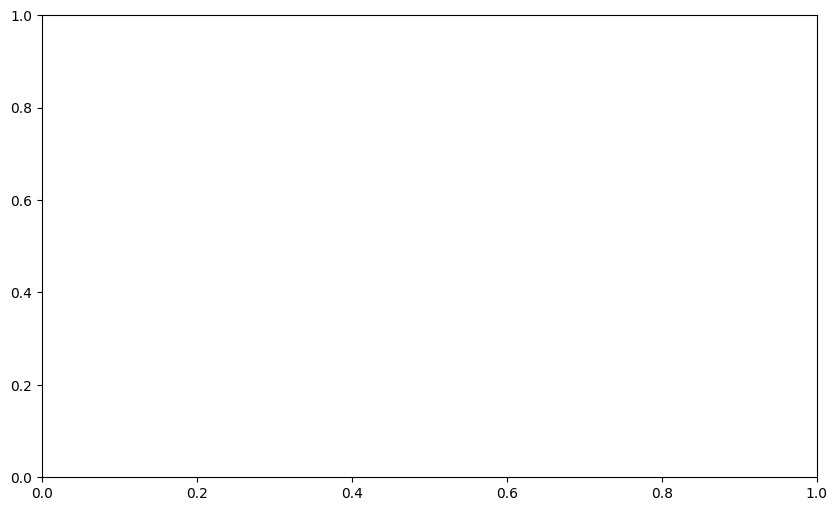

In [41]:
# Coletando os limites de crédito recomendados para cada grupo
limites_recomendados_por_grupo_lista = [limites_recomendados_por_grupo[grupo] for grupo in range(n_clusters)]

# Plotando os limites de crédito recomendados para cada grupo
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(limites_recomendados_por_grupo_lista, labels=[f'Grupo {grupo}' for grupo in range(n_clusters)])
plt.title('Distribuição dos Limites de Crédito Recomendados por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Limite de Crédito Recomendado')
plt.tight_layout()
plt.show()


Validação do Modelo:


In [ ]:
# Calcular RMSE para cada grupo
for grupo in range(n_clusters):
    dados_grupo = dados_sem_nan[dados_sem_nan['grupo_cliente'] == grupo]
    X_grupo = dados_grupo[['maiorAtraso', 'margemBrutaAcumulada', 'percentualProtestos', 'faturamentoBruto']]
    y_grupo = dados_grupo['limiteEmpresaAnaliseCredito']

    X_grupo_imputado, _ = trata_dados(X_grupo)
    X_grupo_padronizado = scaler.transform(X_grupo_imputado)

    previsoes = modelos_por_grupo[grupo].predict(X_grupo_padronizado)
    rmse = root_mean_squared_error(y_grupo, previsoes)
    print(f'RMSE para o Grupo {grupo}: {rmse}')
